In [1]:
import sys

!{sys.executable} -m pip install yfinance --upgrade --no-cache-dir

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=5a46e2a864ac8d6c1654c6f14ad2ab4cc0c56d5afcc315b62dc514e6200eaa2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-enrymzqv/wheels/6f/ad/f4/4a269deab015672fd1ab353d6b2c3fcf64f413980737c13541
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8366 sha256=920f253447eea105f3f67e8e7a7ead7a8e35a8c6b5d163ef3d7d1a3a38ab2555
  Stored in directory: /tmp/pip-ephem-wheel-cache-enrymzqv/wheels/5e/8a/c4/59c699498647c7c94b14c87a904ca7540646107b3d94b7c320
Successfully built yfinance multitasking
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


# ML 응용 : 주식시장 데이터 클러스터링

**목표**: 고차원 공간에서 근접한 이웃을 추정해 냅니다.

1. 마켓플레이스의 [K-Shape: Time Series Clustering](https://aws.amazon.com/marketplace/pp/Spotad-LTD-K-Shape-Time-Series-Clustering/prodview-bjbovimwn5ajs) 알고리즘을 사용하여 시계열 데이터를 클러스터링 합니다.

1. SageMaker의 빌트인 [K-Means Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/k-means.html) 알고리즘을 이용하여 고차원 데이터를 클러스터링합니다.



#### Task 1 설명:
첫 번째 과제에서는 시계열 데이터를 클러스터링하고, 주어진 기간 동안 서로 동일한 성과를 내는 주식을 찾아내는 방법을 배웁니다. 진행과정에서 주식시장 데이터를 다운로드 하고, 각 주가를 정규화한 후, 고유한 모양을 가지는 주식 클러스터를 식별할 것입니다. 그 다음 어떤 주식이 동일한 패턴을 보이는지 살펴보고 정리합니다. 여러가지 K (2~20)값을 시도하여 최소 SSD (Sum of the squared distances, 각 데이터포인트와 클러스터 중심사이의 거리 제곱의 합)를 리턴하는  `k`를 찾아냅니다. 

Task 2를 위해 보다 많은 시간을 투자하실 수 있도로 Task1은 보다 많은 구분을 이미 구현한 형태로 준비하였습니다.


#### *References:*

* [K-means 블로그](https://aws.amazon.com/blogs/machine-learning/k-means-clustering-with-amazon-sagemaker/)
* [AWS 마켓플레이스의 알고리즘과 모델을 이용하여 ML 프로젝트 가속화하기(동영상))](https://youtu.be/OrmHHVI1uPk?t=1682)
* [그래프 등 참고 예제](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/aws_marketplace/using_model_packages/financial_transaction_processing/Extracting_insights_from_your_credit_card_statement.ipynb)

#### Task 2 설명:
본 과제에서는 고차원 공간에서 클러스터링 알고리즘을 적용하여 어떻게 근접한 이웃을 근사하는지를 배우게 됩니다. 본 작업의 일부분으로, 처음은 주식 종목 포트폴리오를 포함하는 고차원 데이터셋을 합성할 것이고, 그 다음 이 데이터셋에 K-Means 클러스터링 알고리즘을 적용하여 유사한 포트폴리오를 가지는 투자자의 군집을 구별하게 됩니다. 

**Notes**:

* 프로젝트에 재미를 더하기 위해, 특정 종목을 리스트에 추가해 보십시오. 

* 프로젝트 시간이 남는 경우 Task1과 Task2 문제를 풀 수 있는 다른 알고리즘을 시도해 보고 적절한 매트릭으로 결과를 비교해 보십시오.

#### *References:*

* [K-means 블로그](https://aws.amazon.com/blogs/machine-learning/k-means-clustering-with-amazon-sagemaker/)
* [K-Means 동작방식(SageMaker 개발자 가이드)](https://docs.aws.amazon.com/sagemaker/latest/dg/algo-kmeans-tech-notes.html)


In [42]:
# 본 실험에서는 다음 주식 종목 들을 사용하겠습니다.
tickers = ['FB','AAPL','MSFT','GOOGL','GOOG','JNJ','V','PG','JPM','UNH','HD','MA','INTC','NVDA','VZ','NFLX','ADBE','DIS','T','PYPL','PFE','MRK','CSCO','CMCSA','WMT','PEP','BAC','XOM','KO','CRM','ABBV','ABT','CVX','TMO','AMGN','COST','MCD','ACN','LLY','BMY','NEE','MDT','AVGO','LIN','TXN','DHR','UNP','NKE','AMT','ORCL','PM','IBM','LOW','HON','QCOM','C','GILD','BA','WFC','RTX','LMT','MMM','BLK','SBUX','FIS','SPGI','NOW','CHTR','CVS','UPS','VRTX','BDX','INTU','ISRG','MDLZ','MO','CAT','CCI','BKNG','PLD','ZTS','AMD','REGN','GS','ANTM','D','CI','EQIX','APD','ADP','CL','ATVI','MS','AXP','TJX','SYK','CB','TMUS','TGT']

In [3]:
import os
import json
import boto3
import sagemaker
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import sagemaker as sage
import yfinance as yf
import botocore
from sklearn import preprocessing
from uuid import uuid4
from collections import namedtuple
from functools import partial
from scipy.stats import zscore
from sagemaker import AlgorithmEstimator
from matplotlib.pyplot import figure
import warnings
import matplotlib.dates as mdates
from sagemaker.predictor import csv_serializer
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
%matplotlib inline

#visualization variables
palette=sns.color_palette("RdBu", n_colors=7)

In [4]:
#Common variable declaration
region_name = boto3.Session().region_name
bucket=sage.Session().default_bucket()
role = sage.get_execution_role()
sagemaker_session = sage.Session()

환경에 따라 다음 warning이 발생할 수 있습니다. 셀이 성공적으로 실행되었는지 확인합니다. 

`Couldn't call 'get_role' to get Role ARN from role name Sagemaker_Studio_Role to get Role path.`

## Task 1:
본 프로젝트에서 여러분은 고유한 모양을 가지는 주식을 찾을 것입니다. 이 작업은 다음 세 가지 단계로 나누어집니다.

##### Step 1:
* 95일 동안의 주식시장 데이터를 다운로드하고 알고리즘에서 사용하는 포맷의 파일로 변환합니다. 알고리즘은 csv포맷의 정규화된 시계열 데이터를 요구합니다. 데이터의 각 행(row)은 특정 주식에 대한 시계열 정보로 표현되어야 합니다.

##### Step 2:
* 모양기반으로 시계열을 클러스터링하고 유사한 패턴의 주식 클러스터를 식별합니다. - 여기서 시계열의 크기(magnitude)가 아닌 모양(shape)에 집중하는 것에 주목해 주십시오. 

##### Step 3:
실험을 진행하고 발견한 내용을 보고합니다. 


첫번째 과제에서, [AWS Marketplace](https://aws.amazon.com/marketplace/search/results?page=1&filters=fulfillment_options&fulfillment_options=SAGEMAKER&ref_=header_nav_dm_sagemaker)에 있는 [K-Shape Time Series Clustering](https://aws.amazon.com/marketplace/pp/Spotad-LTD-K-Shape-Time-Series-Clustering/prodview-bjbovimwn5ajs) 알고리즘을 사용합니다. K-Shape Time Series Clustering 알고리즘은 다음 [연구 논문](
http://web2.cs.columbia.edu/~gravano/Papers/2015/sigmod2015.pdf)에 기반합니다.

In [26]:
# 데이터를 다운로드할 대상 기간을 설정합니다. 
start_date = '2020-02-03'
end_date = '2020-06-18'
common_prefix = "k-shape-clustering"


In [27]:
# 정의된 모든 종목에 대하여 주식 정보를 다운로드하고 데이터프레임을 생성합니다. 
data = yf.download(' '.join(tickers), start=start_date, end=end_date, group_by="ticker")

[*********************100%***********************]  99 of 99 completed


In [43]:
data.head(10)

TMUS                                                        \
                 Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2020-02-03  80.360001  80.760002  79.330002  79.459999  79.459999   2879800   
2020-02-04  80.150002  81.889999  79.230003  81.510002  81.510002   4597800   
2020-02-05  81.959999  82.709999  81.750000  81.790001  81.790001   2758800   
2020-02-06  82.129997  83.080002  82.000000  82.769997  82.769997   2976200   
2020-02-07  83.370003  85.790001  82.260002  85.440002  85.440002   6740600   
2020-02-10  85.410004  85.650002  84.379997  84.529999  84.529999   3423100   
2020-02-11  93.699997  95.230003  92.660004  94.489998  94.489998  25874400   
2020-02-12  94.000000  96.269997  93.919998  95.669998  95.669998   8915500   
2020-02-13  95.120003  96.150002  94.800003  95.139999  95.139999   5490500   
2020-02-14  95.260002  96.620003  95.019997  96.480003  96.480003   3045900   

                   FIS                                      ...        MRK  \
                  Open        High         Low       Close  ...        Low   
Date                                                        ...              
2020-02-03  145.100006  145.979996  144.300003  145.750000  ...  86.040001   
2020-02-04  147.179993  148.839996  146.889999  147.419998  ...  88.059998   
2020-02-05  148.440002  149.130005  144.940002  146.119995  ...  84.000000   
2020-02-06  146.470001  147.559998  145.869995  147.339996  ...  85.260002   
2020-02-07  146.820007  147.089996  145.899994  146.460007  ...  84.830002   
2020-02-10  146.160004  150.380005  146.009995  149.979996  ...  84.940002   
2020-02-11  150.509995  150.929993  149.199997  149.509995  ...  84.949997   
2020-02-12  149.149994  149.580002  147.449997  147.960007  ...  82.900002   
2020-02-13  148.850006  156.820007  147.479996  154.320007  ...  81.449997   
2020-02-14  154.350006  158.210007  153.869995  157.440002  ...  81.669998   

                                                  PFE                        \
                Close  Adj Close    Volume       Open       High        Low   
Date                                                                          
2020-02-03  87.339996  85.941246   9286100  37.459999  38.040001  37.299999   
2020-02-04  88.360001  86.944908  14400100  38.080002  38.240002  37.630001   
2020-02-05  85.830002  84.455437  27948600  37.849998  38.570000  37.820000   
2020-02-06  85.680000  84.307831  15372300  38.439999  38.500000  38.029999   
2020-02-07  85.080002  83.717445  10896400  38.360001  38.400002  37.930000   
2020-02-10  85.660004  84.288155  10105900  38.209999  38.220001  37.720001   
2020-02-11  85.250000  83.884712   9783100  37.889999  38.130001  37.759998   
2020-02-12  83.250000  81.916740  18731800  38.090000  38.189999  37.720001   
2020-02-13  81.970001  80.657249  18500700  37.580002  37.580002  36.889999   
2020-02-14  82.650002  81.326363   8343000  36.970001  37.040001  36.419998   

                                            
                Close  Adj Close    Volume  
Date                                        
2020-02-03  37.509998  36.780388  19806200  
2020-02-04  37.689999  36.956886  29554900  
2020-02-05  38.169998  37.427547  27935000  
2020-02-06  38.259998  37.515797  19969400  
2020-02-07  38.049999  37.309883  20781400  
2020-02-10  37.810001  37.074554  18973800  
2020-02-11  38.090000  37.349106  15206200  
2020-02-12  37.740002  37.005917  21768800  
2020-02-13  36.930000  36.211670  20967500  
2020-02-14  36.509998  35.799839  19930500  

[10 rows x 594 columns]

In [8]:
# 주식값이 가용한 날짜를 뽑아 컬럼으로 지정합니다.
dates=data[tickers[0]]['Close'].index

In [9]:
len(dates)
##df[dates].values

95

본 실험에서는 여러 측정값 중 종가(closing price)를 사용하겠습니다.

In [10]:
close_data=[]

for ticker in tickers:
    ticker_data=[ticker]
    ticker_data.extend(data[ticker]['Close'].values)
    close_data.append(ticker_data)

#print('Closing price data set for ',len(close_data),' tickers')
#print(close_data[0])

리스트로 선언된 `close_data`는 종목별 주가의 시계열 정보를 담고 있습니다. 이 데이터를 데이터프레임으로 변환합니다.

In [11]:
columns=['Ticker']
columns.extend(dates)

df=pd.DataFrame(data=close_data,columns=columns)

In [12]:
df.head()

,Ticker,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,...,2020-06-04 00:00:00,2020-06-05 00:00:00,2020-06-08 00:00:00,2020-06-09 00:00:00,2020-06-10 00:00:00,2020-06-11 00:00:00,2020-06-12 00:00:00,2020-06-15 00:00:00,2020-06-16 00:00:00,2020-06-17 00:00:00
0,FB,204.190002,209.830002,210.110001,210.850006,212.330002,213.059998,207.190002,210.759995,213.139999,...,226.289993,230.770004,231.399994,238.669998,236.729996,224.429993,228.580002,232.500000,235.649994,235.529999
1,AAPL,77.165001,79.712502,80.362503,81.302498,80.007500,80.387497,79.902496,81.800003,81.217499,...,80.580002,82.875000,83.364998,85.997498,88.209999,83.974998,84.699997,85.747498,88.019997,87.897499
2,MSFT,174.380005,180.119995,179.899994,183.630005,183.889999,188.699997,184.440002,184.710007,183.710007,...,182.919998,187.199997,188.360001,189.800003,196.839996,186.270004,187.740005,188.940002,193.570007,194.240005
3,GOOGL,1482.599976,1445.410034,1446.050049,1475.969971,1479.109985,1508.660034,1510.060059,1518.630005,1513.390015,...,1414.300049,1440.020020,1448.040039,1452.079956,1464.699951,1401.900024,1412.920044,1420.739990,1446.469971,1452.540039
4,GOOG,1485.939941,1447.069946,1448.229980,1476.229980,1479.229980,1508.680054,1508.790039,1518.270020,1514.660034,...,1412.180054,1438.390015,1446.609985,1456.160034,1465.849976,1403.839966,1413.180054,1419.849976,1442.719971,1451.119995


여기까지 다른 문제는 없어보입니다. 이제 이 데이터를 행(row) 단위로 정규화하고 파일로 저장합니다. 

In [13]:
x = df[dates].values
len(x)

99

In [14]:
x[0]

array([204.19000244, 209.83000183, 210.11000061, 210.8500061 ,
       212.33000183, 213.05999756, 207.19000244, 210.75999451,
       213.13999939, 214.17999268, 217.80000305, 217.49000549,
       214.58000183, 210.17999268, 200.72000122, 196.77000427,
       197.19999695, 189.75      , 192.47000122, 196.44000244,
       185.88999939, 191.75999451, 185.16999817, 181.08999634,
       169.5       , 178.19000244, 170.24000549, 154.47000122,
       170.27999878, 146.00999451, 149.41999817, 146.96000671,
       153.13000488, 149.72999573, 148.1000061 , 160.97999573,
       156.21000671, 163.33999634, 156.78999329, 165.94999695,
       166.80000305, 159.6000061 , 158.19000244, 154.17999268,
       165.55000305, 168.83000183, 174.27999878, 175.19000244,
       174.78999329, 178.16999817, 176.97000122, 176.25      ,
       179.24000549, 178.24000549, 170.80000305, 182.27999878,
       185.13000488, 190.07000732, 187.5       , 182.91000366,
       194.19000244, 204.71000671, 202.27000427, 205.25

In [15]:
# 컬럼(column)이 아닌 행(row)을 기준으로 정규화하기 위해 먼저 전치(transpose)한 후 MinMaxScaler를 적용합니다. .
# 정규화 이후에는 다시 결과를 전치(transpose)하여 원래의 포맷으로 복원합니다. 
minmax_scale = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(x.T)
x_scaled=minmax_scale.transform(x.T).T

In [16]:
x_scaled[0]

array([ 0.25577392,  0.37750928,  0.38355285,  0.39952534,  0.43146999,
        0.44722643,  0.32052678,  0.3975825 ,  0.44895321,  0.47140072,
        0.54953606,  0.54284499,  0.48003463,  0.38506358,  0.18087642,
        0.09561856,  0.10489964, -0.05590322,  0.00280606,  0.0884957 ,
       -0.13921858, -0.01251893, -0.15475929, -0.24282322, -0.49298501,
       -0.30541751, -0.47701252, -0.8173968 , -0.47614929, -1.        ,
       -0.92639751, -0.97949467, -0.84631966, -0.91970643, -0.95488859,
       -0.67688322, -0.77984002, -0.62594429, -0.76732143, -0.56960929,
       -0.55126251, -0.70666931, -0.73710323, -0.82365642, -0.57824287,
       -0.50744644, -0.38981215, -0.37017037, -0.37880428, -0.30584929,
       -0.33175037, -0.34729108, -0.28275395, -0.30433823, -0.46492537,
       -0.21713786, -0.15562252, -0.04899609, -0.10446786, -0.20353966,
        0.03993106,  0.26699784,  0.21433213,  0.27886893,  0.31793677,
        0.34815464,  0.40837465,  0.43190177,  0.44981644,  0.38

In [17]:
file_name='train.csv'

# 수정된 컬럼값을 데이터프레임으로 생성합니다. `Ticker`컬럼을 추가하고 이후 학습작업에서 알고리즘에 입력할 수 있도록 파일로 저장합니다. 
df = pd.DataFrame(x_scaled)
df.insert(0,'Ticker',tickers)
df.to_csv(file_name,header=False,index=False)

In [18]:
df.head()

,Ticker,0,1,2,3,4,5,6,7,8,...,85,86,87,88,89,90,91,92,93,94
0,FB,0.255774,0.377509,0.383553,0.399525,0.431470,0.447226,0.320527,0.397583,0.448953,...,0.732786,0.829484,0.843082,1.000000,0.958126,0.692640,0.782215,0.866825,0.934815,0.932225
1,AAPL,0.312213,0.470849,0.511326,0.569861,0.489219,0.512882,0.482681,0.600841,0.564568,...,0.524870,0.667782,0.698295,0.862225,1.000000,0.736281,0.781427,0.846657,0.988168,0.980540
2,MSFT,0.268642,0.455552,0.448388,0.569847,0.578313,0.734940,0.596223,0.605015,0.572452,...,0.546727,0.686096,0.723869,0.770759,1.000000,0.655813,0.703680,0.742755,0.893520,0.915337
3,GOOGL,0.820410,0.662404,0.665123,0.792242,0.805583,0.931130,0.937078,0.973489,0.951226,...,0.530229,0.639504,0.673578,0.690742,0.744360,0.477546,0.524366,0.557590,0.666907,0.692697
4,GOOG,0.826622,0.661242,0.666178,0.785309,0.798073,0.923374,0.923842,0.964176,0.948817,...,0.512796,0.624312,0.659285,0.699917,0.741145,0.477312,0.517051,0.545429,0.642734,0.678474


In [19]:
#Next, we will upload it to Amazon S3 so that we can specify the same as part of the training job in Step 2.
train_file = sagemaker_session.upload_data(file_name, bucket, common_prefix)

#### Step 2: ML 모델 학습(Training)

AWS 마켓플리이스의 3rd party 알고리즘을 SageMaker에서 사용하기 위해 구독(subscript) 절차가 필요합니다.

1. [AWS 마켓플레이스 리스트 페이지](https://aws.amazon.com/marketplace/pp/Spotad-LTD-K-Shape-Time-Series-Clustering/prodview-bjbovimwn5ajs)에서 알고리즘을 오픈합니다.
1. **Continue to subscribe** 버튼을 클릭합니다.
1. ***Subscribe to this software*** 페이지에서 EULA, 가격, 지원정책 등 내용을 확인하고 동의하시는 경우, **"Accept Offer"** 버튼을 클릭합니다. AWS에서 실행되는 워크샾에서 제공하는 노트북에서는 이미 이 과정이 진행되었을 수 있습니다.
1. **Continue to configuration** 버튼을 클릭하고 알고리즘을 사용할 (SageMaker 노트북이 실행중인) **region** 을 선택합니다. 
1. **Product Arn**을 복사합니다. 복사한 값을 다음 셀의 `algo_arn`변수에 저장합니다.



In [20]:
algo_arn='<아래를 참고하여 사용하시는 리전에 맞는 algorithm ARN 을 입력합니다.>'

#algo_arn='arn:aws:sagemaker:us-east-1:865070037744:algorithm/k-shape-cd639040558775d27d890f1479c92d7b'

In [21]:
# hyperparameters 부분을 살펴보십시오. (11개의 클러스터를 위해 k=11 로, 첫번째 컬럼이 ticker를 구분하고 있으므로 label-size=1 로 지정하였습니다.)
# 인스턴스 타입을 확인하고 ML 모델 학습을 실행합니다. 
algo = AlgorithmEstimator(algorithm_arn=algo_arn, 
                          role=role, 
                          train_instance_count=1, 
                          train_instance_type='ml.m5.4xlarge', 
                          sagemaker_session=sagemaker_session, 
                          base_job_name=common_prefix,
                          hyperparameters={"k": "11", "label_size": "1"}) 

algo.fit({'train': train_file}) 


's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-13 02:23:13 Starting - Starting the training job...
2020-09-13 02:23:16 Starting - Launching requested ML instances......
2020-09-13 02:24:31 Starting - Preparing the instances for training......
2020-09-13 02:25:37 Downloading - Downloading input data
2020-09-13 02:25:37 Training - Downloading the training image...
2020-09-13 02:26:10 Uploading - Uploading generated training model
2020-09-13 02:26:10 Completed - Training job completed
Train procedure started
Data contains time series of length 95
Starting iteration 1
Sum Square Distance: 4.723133655722873
Finished iteration 1
Starting iteration 2
Sum Square Distance: 3.617445046962214
Finished iteration 2
Starting iteration 3
Sum Square Distance: 3.429237509701197
Finished iteration 3
Starting iteration 4
Sum Square Distance: 3.30081633603084
Finished iteration 4
Starting iteration 5
Sum Square Distance: 3.156997575151441
Finished iteration 5
Starting iteration 6
Sum Square Distance: 3.126708308652487
Finished iteration 6
Star

이제 알고리즘이 생성한 ML 모델을 다운로드할 수 있으며, 모델은 중심(centroid)에 대한 정보를 포함하고 있습니다. 클러스터 중심(Cluster centroid)은 각 클러스터에서 변량들의 평균입니다. 본 사례에서는 클러스터에서 발견된 시계열 관측에 대한 클러스터 중심을 시계열로 생성되었습니다. 

클러스터가 어떤 점에 소속되는지를 알기 위하여 알고리즘은 모든 클러스터의 중앙(centor)로부터 시계열들의 거리를 찾습니다. 알고리즘은 다시 가장 가까운 거리를 가지는 클러스터를 소속 클러스터로 선택할 것입니다. 

모델을 다운로드하고 클러스터 중심을 그래프로 그려보겠습니다.

In [22]:
s3 = boto3.resource('s3')

try:
    s3.Bucket(bucket).download_file('{}/output/model.tar.gz'.format(algo._current_job_name), 'model.tar.gz')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [23]:
!mkdir -p model
!tar -zxvf model.tar.gz -C model

centroids


In [24]:
split_by_comma = lambda s: str.split(s, ',')

centroids = list()
with open('model/centroids', 'r') as f:
    for index,record in enumerate(map(split_by_comma, list(map(str.strip, f)))):
        centroid=np.array(record).astype(float)
        centroids.append(centroid)
len(centroids)

11

식별된 클러스터들의 중심을 그래프로 그려봅니다.


중심값들은 Z 정규화되어 있으므로 실제 주가의 범위와 매치되지는 않습니다.

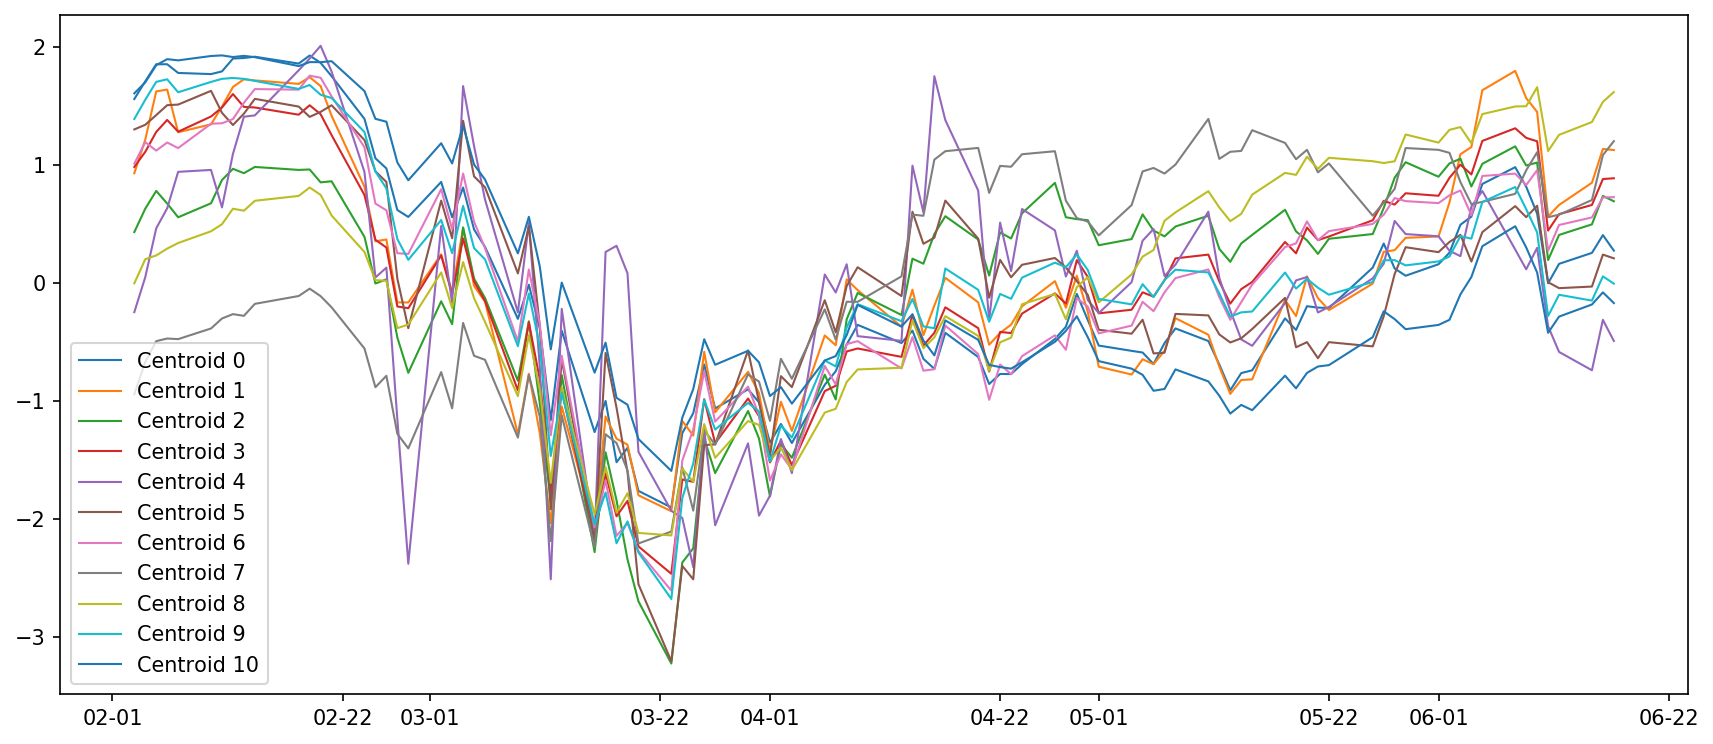

In [25]:
figure(num=None, figsize=(14, 6), dpi=150, facecolor='w', edgecolor='k')

#Display only month and day
formatter = mdates.DateFormatter("%m-%d")
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)


for index,centroid in enumerate(centroids):
    plt.plot( dates, centroid, linewidth=1, label='Centroid '+str(index))
plt.legend()


추론을 위해 ML 모델을 SageMaker 엔드포인트로 배포합니다.

In [40]:
%%time
predictor = algo.deploy(1, 'ml.m5.4xlarge', serializer=csv_serializer)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


...........
-----------!CPU times: user 211 ms, sys: 16.8 ms, total: 228 ms
Wall time: 6min 25s


In [41]:
single_result=df.head(1).values[0]
result=predictor.predict(np.array(single_result[1:])).decode('utf-8')
result

'8,0.016993166245023672,0'

<font color='red'> 워크샵에 참여하시는 분들의 과제 : 전체 학습데이터셋에 대하여 추론을 실행하고 각 행(row)에 대한 클러스터 아이디를 식별하십시오. 각 클러스트들을 별도의 선그래프로 그려서 가시화하십시오. </font>  
<font color='red'> 그리고, 여러분이 발견한 내용을 정리하십시오. </font>

In [ ]:
#predictor.delete_endpoint()

축하합니다. K-shape기반의 시계열 클러스터링을 성공적으로 수행하셨습니다. 

#### 과제 요약

<font color='red'>Task: 다음으로 팀내 구성원들끼리 나누어서 K값을 2부터 20까지 변화시키면서 실험을 진행해 보십시오. (Step 2 모델 학습 단계) 그리고 다음 섹션에서 SSD(Sum Square Distance)를 기록하고 비교하십시오.  </font>
    
본 실험에서는 Automatic model tuning을 실행하지 않기를 권장합니다. 본 과제의 목적은 모든 팀 멤버가 문제 해결을 위한 실험과정을 이해한 후 두번째 Task 2를 보다 효과적으로 해결하는 것입니다. (Task 2를 완료하고 시간이 남는 경우 추가로 진행해도 좋겠습니다.)

실험을 위해 다른 종목과 날짜 범위를 선택할 수 있습니다. 이 경우, 다음 범위내에서 지정하도록 가이드드립니다.:
1. 50개 종목 이상 
2. 3개월 이상의 기간



##### 실험결과 정리 샘플:
<font color='red'>Tickers =[]

Date range=[]


| K      | Sum Square Distance |
| ----------- | ----------- |
| ...      | ...       |
| ...      | ...       |



다음 질문에 대답해 봅니다. 
* "K"값이 얼마일 경우 가장 좋은 결과를 보이나요?
* 동일 섹터의 종목이 모두 유사한 모양을 가지고 있나요?
* 그래프를 통해 어떤 흥미로은 패턴을 발견할 수 있나요?
    
</font>

팀원이 각각 과제를 끝내고 나면, Task2는 팀전체가 함께 작업합니다. 


### Task 2 설명

주식시장의 변덕스러운 특징에도 불구하고, 많은 사람들이 주식에 투자합니다. 투자자들은 고유한 주식 포트폴리오를 고민합니다. 포트폴리오를 구성하는 수량과 구매 날짜는 다양하겠지만, 투자자들의 포트폴리오가 유일할 가능성은 매우 낮을 것입니다.  

본 과제에서는 10만명의 투자자들에 대하여 3개~10개의 종목으로 구성된 가상의 포트폴리오를 생성하고 클러스터링해 보겠습니다.


##### Step 1:

주어진 종목 집합(SPDR SP 500 ETF:(SPY)의 서브그룹) 에 대한 투자자 2만명의 포트폴리오를 생성합니다. 각 투자자에게는 고유의 아이디를 부여합니다. 


##### Step 2:
       
K-Means 클러스터링 알고리즘을 이용하여 포트폴리오에 대한 클러스터링을 수행합니다. 

    K-means는 비지도 학습 알고리즘입니다. 이 알고리즘은 가능한한 서로 유사한 멤버 데이터를 가지고, 가능한한 서로 다른 클러스터를를 가지게 되는 고유의 그룹을 찾습니다. 알고리즘 실행과정에서 유사도를 결정할 속성들을 정의할 것입니다. Amazon SageMaker는 수정된 버전의 web-scale k-means 클러스터링 알고리즘을 제공합니다. 수정된 알고리즘은 원본에 비하여 조금 더 높은 정확도를 제공하며, 원본 알고리즘과 같이 대량 데치터셋에 대한 확정성을 제공하고, 보다 빠르게 학습할 수 있습니다. 
    
K-means에 대한 보다 상세한 내용은 [개발자 가이드](https://docs.aws.amazon.com/sagemaker/latest/dg/k-means.html)를 참고합니다.
##### Step 3:
투자자 아이디를 입력받고 해당 투자자와 유사한 포트폴리오를 가지는 다른 투자자를 식별하는 함수를 생성합니다. 

서로 다른 "K"값을 이용하여 실험을 진행하고 결과를 정리합니다. 

**구현 팁**: 지연시간을 최소화하기 위해 작은 데이터셋에서부터 시작하고 큰 데이터셋에 대한 실험으로 확장해 갑니다.

### Step 1: 포트폴리오 생성


`데이터프레임 컬럼 가이드`: ['TRADER_ID','Ticker1','Ticker2','Ticker3','Ticker4'...'TickerN']

In [46]:
num_traders=20000
min_stocks_in_portfolio=3
max_stocks_in_portfolio=10

In [47]:
df = pd.DataFrame(columns=tickers)

In [48]:
from random import randrange

#Each trader's portfolio must contain 3 companies and at-most 10 companies.
portfolios=[]
for trader_number in range(num_traders):
    total_stocks= randrange(min_stocks_in_portfolio, max_stocks_in_portfolio)
    for num_stock in range(total_stocks):
        df.loc[trader_number, tickers[randrange(len(tickers))]] = 1

**구현 팁**: 학습에 많은 시간이 걸린다면 더 높은 사양의 인프라로 시도해 보십시오. 


### Step 2:
<font color='red'>
본 단계에서 생성된 서로다른 포트폴리오 데이터들을 클러스터링하는 ML 모델에 대한 학습코드를 작성합니다. </font>


### Step 3:
<font color='red'>
이 단계에서 투자자를 선택하는 데 필요한 코드를 작성한 다음 선택한 트레이더의 포트폴리오와 동일한 포트폴리오에 종목이 있는 다른 사람을 찾습니다. </ font>


### Step 4: Identify optimal value for K and report metrics (Optional)

다음 블로그를 참조합니다.  
https://aws.amazon.com/blogs/machine-learning/k-means-clustering-with-amazon-sagemaker/ 
    
블로그 게시물과 동일한 실험을 수행해 보고, 그래프를 플로팅하고, 결과를 정리합니다.